In [4]:
import requests
from tqdm import tqdm_notebook
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from joblib import load, dump
import os


# all texts available for analysis
texts = \
[('moby_dick',"https://www.gutenberg.org/files/2701/2701-0.txt"),
('huck_finn',"http://www.gutenberg.org/files/76/76-0.txt"),
('great_expectations',"http://www.gutenberg.org/files/1400/1400-0.txt"),
('tale_two_cities',"http://www.gutenberg.org/files/98/98-0.txt"),
('jekyll_hyde', "http://www.gutenberg.org/files/11/11-0.txt"),
('wuthering_heights',"http://www.gutenberg.org/cache/epub/768/pg768.txt"),
('beowulf', 'http://www.gutenberg.org/cache/epub/16328/pg16328.txt'),
('anthem', 'https://www.gutenberg.org/files/1250/1250-0.txt'),
('frankenstein', 'https://www.gutenberg.org/files/84/84-0.txt'),
('scarlet_letter', 'https://www.gutenberg.org/files/25344/25344-0.txt'),
('awakening','https://www.gutenberg.org/files/160/160.txt'),
('yellow_wallpaper', 'https://www.gutenberg.org/files/1952/1952-0.txt'),
('turn_of_the_screw', 'https://www.gutenberg.org/files/209/209-0.txt'),
('great_gatsby','http://gutenberg.net.au/ebooks02/0200041.txt'),
('oliver_twist','https://www.gutenberg.org/files/730/730.txt'),
('1984','http://gutenberg.net.au/ebooks01/0100021.txt'),
('metamorphosis', 'http://www.gutenberg.org/cache/epub/5200/pg5200.txt'),
('jane_eyre','http://www.gutenberg.org/cache/epub/1260/pg1260.txt'),
('tom_sawyer','https://www.gutenberg.org/files/74/74-0.txt'),
('uncle_toms_cabin', 'https://www.gutenberg.org/files/203/203-0.txt')]

def clean_text(text):
    'remove gutenberg formatting'
    try:
        start = text.index("START OF THIS PROJECT GUTENBERG EBOOK")
        end = text.index("END OF THIS PROJECT GUTENBERG EBOOK")
    except:
        try:
            start = text.index("START OF THE PROJECT GUTENBERG EBOOK")
            end = text.index("END OF THE PROJECT GUTENBERG EBOOK")
        except:
            try:
                start = text.index("Title: The Great Gatsby Author: F. Scott Fitzgerald")
                end = text.index("THE END")
            except:
                start = text.index("Title: Nineteen eighty-four Author: George Orwell (pseudonym of Eric Blair)")
                end = text.index("THE END")

                
            
    clean_text = text[start:end]
    assert len(clean_text)>.5*len(text)
    return clean_text

def get_text(url):
    'fetch txt for a given url'
    
    resp = requests.get(url)
    text = resp.text.replace('nigger', 'SLUR')
    text = ''.join(char for char in text if ord(char) < 128)
    text = ' '.join(text.split())

    return clean_text(text) 

def run(texts):
    
    df=[]
    for t in tqdm_notebook(texts):
        df.append((t[0], get_text(t[1])))
        
        
    df = pd.DataFrame(df)

    tfidf = TfidfVectorizer(max_features=10000, max_df=.5, lowercase=False, )
    dff = pd.DataFrame(tfidf.fit_transform(df[1]).todense())
    dff['title'] = df[0]
    
    return dff, df, tfidf

if os.path.exists('data/texts.dat'):
    dff, df, tfidf = load('data/texts.dat')
    assert(len(dff) == len(texts)), 'saved data does not match requested texts'
else:
    dff, df, tfidf = run(texts)  
    dump([dff, df, tfidf], 'data/texts.dat')

## 1. Extract KWIC and lexical dispersion plots for keywords of interest

In [5]:
from re import finditer
from itertools import tee, islice, chain, repeat
from pprint import pprint 
from prettytable import PrettyTable
from IPython.display import HTML
from ipywidgets.widgets import interact
import numpy as np
from matplotlib import pyplot as plt

def kwic(text, tgtword, width=10):
    'Find all occurrences of tgtword and show the surrounding context'
    matches = (mo.span() for mo in finditer(r"[A-Za-z\'\-]+", text))
    padded = chain(repeat((0,0), width), matches, repeat((-1,-1), width))
    t1, t2, t3 = tee((padded), 3)
    t2 = islice(t2, width, None)
    t3 = islice(t3, 2*width, None)
    for (start, _), (i, j), (_, stop) in zip(t1, t2, t3):
        if text[i: j] == tgtword:
            context = text[start: stop]
            yield context, (i,j)
            

@interact(word='', title=dff.title, size=range(10,25))
def get_kwic(title='awakening',word='love', size=25):
    
    text = str(df[df[0]==title][1].values)
    
    poss=[]
    rows=[]
    for t, pos in list(kwic(text, word, size)):       
        cols = t.split()

        left = ' '.join(cols[0:int(size)])
        right = ' '.join(cols[int(size)+1:-1])
        rows.append([left, word, right])
        poss.append(pos)

    x = PrettyTable()
    x.field_names = ['left','word','right']
    for r in rows:
        x.add_row(r)
        
    if len(rows):
        dispersion_plot =  np.zeros(len(text))
        for p in poss:
            dispersion_plot[p[0]:p[1]] = 1

        plt.figure(figsize=(12,5))
        
        s = pd.Series(dispersion_plot).rolling(5000).sum()
        s = pd.DataFrame(s).reset_index()
        s['index'] = s['index']/(len(s)/100)
        s.set_index('index', inplace=True)
        ax=plt.gca()
        s.plot(ax=ax)
        
        table = x.get_html_string().replace(word,'<b>'+word+'</b>')
        
        return HTML(table)

interactive(children=(Dropdown(description='title', index=10, options=('moby_dick', 'huck_finn', 'great_expect…

## 2. Extract Contextual Stats

In [6]:
@interact(word='', title=dff.title, size=range(11,27,2))
def get_mi(title='moby_dick',word='nature', size=27):

    text = str(df[df[0]==title][1].values)
    cv_all = CountVectorizer(max_features=100000,stop_words='english', lowercase=True)
    m_all = cv_all.fit_transform([text]).todense().flatten()

    texts = []
    for t,pos in list(kwic(text, word, size)):       
        cols = t.split(' ')
        left = ' '.join(cols[0:int(size)])
        right = ' '.join(cols[int(size)+1:-1])
        texts.append(left +' ' + right)

    if len(texts):

        cv = CountVectorizer(max_features=10000, stop_words='english',lowercase=True)
        m = cv.fit_transform(texts)

        hits = m.shape[0]

        names = cv.get_feature_names()
        m = m.todense().sum(axis=0)

        inds = []
        D = {}
        for i,item in enumerate(cv_all.get_feature_names()):
            D[item] = i


        for n in names:
            inds.append(D[n])

        a = np.asarray(m_all[0].tolist()[0])[np.asarray(inds)]

        p_a_b = [_/(hits*size*2) for _ in m]
        p_b = hits/len(text)
        p_a = [_/len(text) for _ in a]

        scores = [(a_b/(a*p_b)) for a_b, a in zip(p_a_b, p_a)]
        
        print("Total number of occurences: {}".format(hits))
        result_list = [(n, s) for n,s in zip(names, scores[0].tolist()[0])]
        result = pd.DataFrame(result_list).sort_values(1, ascending=False).head(25)
        
        return result 
    
    else:
        print('please enter term appearing in document')


interactive(children=(Dropdown(description='title', options=('moby_dick', 'huck_finn', 'great_expectations', '…

## 3. Get top overall words for text

In [7]:
from ipywidgets import interact
@interact(title=dff.title)
def get_top_terms(title='moby_dick'):
    scores = dff[dff.title==title].drop('title', axis=1).values
    inds = scores.argsort()[0][-15:]
    #return 
    result = pd.DataFrame([(a[0],b) for a,b in 
                           zip(np.asarray(tfidf.get_feature_names()).reshape(-1,1)[inds], 
                               scores[0][inds])])
    result.sort_values(1, ascending=False, inplace=True)
    return result 


interactive(children=(Dropdown(description='title', options=('moby_dick', 'huck_finn', 'great_expectations', '…

# 4. Get similarity between all documents

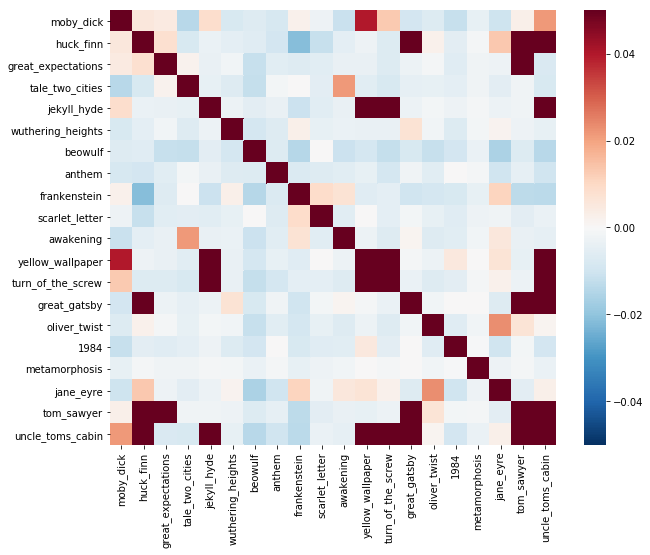

In [8]:
import seaborn as sns

c = dff.drop('title',axis=1).T.corr()
c = c.rename(columns={i:v for i,v in dff.title.items()},index={i:v for i,v in dff.title.items()})
plt.figure(figsize=(10,8))
sns.heatmap(c, vmin=-.05, vmax=.05,cmap="RdBu_r")

pass

In [738]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

n_samples = 2000
n_features = 2000
n_components = 15
n_top_words = 10

def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()
    

def split_str(seq, chunk, skip_tail=False):
    lst = []
    if chunk <= len(seq):
        lst.extend([seq[:chunk]])
        lst.extend(split_str(seq[chunk:], chunk, skip_tail))
    elif not skip_tail and seq:
        lst.extend([seq])
    return lst


lda = LatentDirichletAllocation(n_components=n_components, max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)

cv = CountVectorizer(stop_words='english', lowercase=True)

cv.fit(df[1].values)
tf = cv.transform(df[1].values)


lda.fit(tf)


print("\nTopics in LDA model:")
tf_feature_names = cv.get_feature_names()
print_top_words(lda, tf_feature_names, n_top_words)


Topics in LDA model:
Topic #0: said like know old come little man day good great
Topic #1: said mr old man know come time did hand went
Topic #2: said man come time like mr did looked little good
Topic #3: said man old like mr did little time went think
Topic #4: said mr little like time man ll know tom did
Topic #5: said old like way little got man did know come
Topic #6: said mr time know little old did like way away
Topic #7: said mr time little know good man come like way
Topic #8: said like mr time little did hand old good way
Topic #9: said like time little mr tom did long come man
Topic #10: said mr know little like time did come man head
Topic #11: said little mr know like good tom time come did
Topic #12: said little like time mr know man good come did
Topic #13: said mr like little time man did old know come
Topic #14: said mr time did like man way know say little

